In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
import sys
sys.path.append('../src')
from model_evaluation import evaluate_model_comprehensive, compare_models, get_best_model

print("="*80)
print("MODEL BUILDING AND TRAINING")
print("="*80)
print("1. Build models on BOTH Fraud_Data.csv AND creditcard.csv")
print("2. Logistic Regression (baseline)")
print("3. One Powerful Ensemble Model (Random Forest or XGBoost)")
print("4. Use AUC-PR, F1-Score, Confusion Matrix for evaluation")
print("="*80)

MODEL BUILDING AND TRAINING
1. Build models on BOTH Fraud_Data.csv AND creditcard.csv
2. Logistic Regression (baseline)
3. One Powerful Ensemble Model (Random Forest or XGBoost)
4. Use AUC-PR, F1-Score, Confusion Matrix for evaluation


In [11]:
# DATASET 1: Fraud_Data.csv (already preprocessed in EDA)
print("\n" + "="*60)
print("DATASET 1: FRAUD_DATA.CSV")
print("="*60)

# Load the prepared data from EDA notebook
fraud_data = pd.read_csv('../data/processed/fraud_data_cleaned.csv')
print(f"Fraud_Data.csv shape: {fraud_data.shape}")

# Recreate preprocessing from EDA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

# Prepare features and target
X_fraud = fraud_data.drop(['class', 'signup_time', 'purchase_time'], axis=1)
y_fraud = fraud_data['class']

# Split data
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(
    X_fraud, y_fraud, test_size=0.2, stratify=y_fraud, random_state=42
)

# Preprocessing (recreating EDA steps)
high_cardinality = ['user_id', 'device_id']
categorical_cols = ['source', 'browser', 'sex', 'country']
numeric_cols = [col for col in X_train_fraud.columns if col not in high_cardinality + categorical_cols]

# Drop high-cardinality columns
X_train_fraud_reduced = X_train_fraud.drop(columns=high_cardinality)
X_test_fraud_reduced = X_test_fraud.drop(columns=high_cardinality)

# One-hot encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_fraud_encoded = encoder.fit_transform(X_train_fraud_reduced[categorical_cols])
X_test_fraud_encoded = encoder.transform(X_test_fraud_reduced[categorical_cols])

# Get numeric columns
X_train_fraud_num = X_train_fraud_reduced.drop(columns=categorical_cols).reset_index(drop=True)
X_test_fraud_num = X_test_fraud_reduced.drop(columns=categorical_cols).reset_index(drop=True)

# Combine numeric and encoded categorical features
X_train_fraud_prepared = pd.concat(
    [X_train_fraud_num, pd.DataFrame(X_train_fraud_encoded, columns=encoder.get_feature_names_out(categorical_cols))],
    axis=1
)
X_test_fraud_prepared = pd.concat(
    [X_test_fraud_num, pd.DataFrame(X_test_fraud_encoded, columns=encoder.get_feature_names_out(categorical_cols))],
    axis=1
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_fraud_res, y_train_fraud_res = smote.fit_resample(X_train_fraud_prepared, y_train_fraud.reset_index(drop=True))

# Scale numeric features
scaler_fraud = StandardScaler()
numeric_cols_fraud = [
    'purchase_value', 'age', 'ip_address', 'hour_of_day', 'day_of_week',
    'time_since_signup', 'user_transaction_count', 'device_transaction_count',
    'user_transaction_velocity', 'ip_address_int'
]

X_train_fraud_scaled = X_train_fraud_res.copy()
X_test_fraud_scaled = X_test_fraud_prepared.copy()

X_train_fraud_scaled[numeric_cols_fraud] = scaler_fraud.fit_transform(X_train_fraud_res[numeric_cols_fraud])
X_test_fraud_scaled[numeric_cols_fraud] = scaler_fraud.transform(X_test_fraud_prepared[numeric_cols_fraud])

print(f"Fraud_Data.csv prepared!")
print(f"Training set shape: {X_train_fraud_scaled.shape}")
print(f"Test set shape: {X_test_fraud_scaled.shape}")
print(f"Training class distribution: {np.bincount(y_train_fraud_res)}")


DATASET 1: FRAUD_DATA.CSV
Fraud_Data.csv shape: (151112, 19)
Fraud_Data.csv prepared!
Training set shape: (219136, 200)
Test set shape: (30223, 200)
Training class distribution: [109568 109568]


In [12]:
# DATASET 2: creditcard.csv
print("\n" + "="*60)
print("DATASET 2: CREDITCARD.CSV")
print("="*60)

# Load creditcard.csv
try:
    creditcard_data = pd.read_csv('../data/raw/creditcard.csv')
    print(f"CreditCard.csv loaded successfully! Shape: {creditcard_data.shape}")
    
    # Prepare CreditCard data
    target_col = 'Class' if 'Class' in creditcard_data.columns else 'class'
    X_credit = creditcard_data.drop([target_col], axis=1)
    y_credit = creditcard_data[target_col]
    
    print(f"CreditCard features shape: {X_credit.shape}")
    print(f"CreditCard target shape: {y_credit.shape}")
    
    # Split CreditCard data
    X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
        X_credit, y_credit, test_size=0.2, stratify=y_credit, random_state=42
    )
    
    # Scale CreditCard data (already preprocessed features)
    scaler_credit = StandardScaler()
    X_train_credit_scaled = scaler_credit.fit_transform(X_train_credit)
    X_test_credit_scaled = scaler_credit.transform(X_test_credit)
    
    X_train_credit_scaled = pd.DataFrame(X_train_credit_scaled, columns=X_credit.columns)
    X_test_credit_scaled = pd.DataFrame(X_test_credit_scaled, columns=X_credit.columns)
    
    # Apply SMOTE to CreditCard data
    X_train_credit_res, y_train_credit_res = smote.fit_resample(X_train_credit_scaled, y_train_credit)
    
    print(f"CreditCard data prepared!")
    print(f"Training set shape: {X_train_credit_res.shape}")
    print(f"Test set shape: {X_test_credit_scaled.shape}")
    print(f"Training class distribution: {np.bincount(y_train_credit_res)}")
    
    creditcard_available = True
    
except FileNotFoundError:
    print("ERROR: CreditCard.csv not found in data/raw/ directory!")
    print("TASK REQUIREMENT: Must work with BOTH datasets")
    print("Please ensure creditcard.csv is in the data/raw/ folder")
    creditcard_available = False


DATASET 2: CREDITCARD.CSV
CreditCard.csv loaded successfully! Shape: (284807, 31)
CreditCard features shape: (284807, 30)
CreditCard target shape: (284807,)
CreditCard data prepared!
Training set shape: (454902, 30)
Test set shape: (56962, 30)
Training class distribution: [227451 227451]



MODEL TRAINING ON BOTH DATASETS
TRAINING MODELS MODELS:
1. Logistic Regression (baseline)
2. One Powerful Ensemble Model (Random Forest)

TRAINING ON FRAUD_DATA.CSV

Training Logistic Regression on Fraud_Data.csv...

COMPREHENSIVE EVALUATION: LOGISTIC REGRESSION - FRAUD_DATA

EVALUATION METRICS FOR LOGISTIC REGRESSION - FRAUD_DATA
Accuracy: 0.9431
Precision: 0.7688
Recall: 0.5604
F1-Score: 0.6483
ROC AUC: 0.8364
Average Precision: 0.6559

Macro Averages:
Precision (Macro): 0.8623
Recall (Macro): 0.7715
F1-Score (Macro): 0.8086


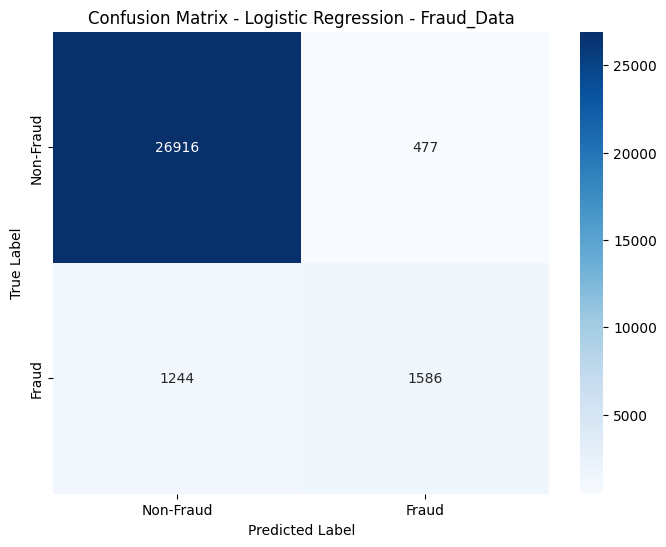


Confusion Matrix Details:
True Negatives (TN): 26916
False Positives (FP): 477
False Negatives (FN): 1244
True Positives (TP): 1586
Specificity (True Negative Rate): 0.9826
Sensitivity (True Positive Rate): 0.5604


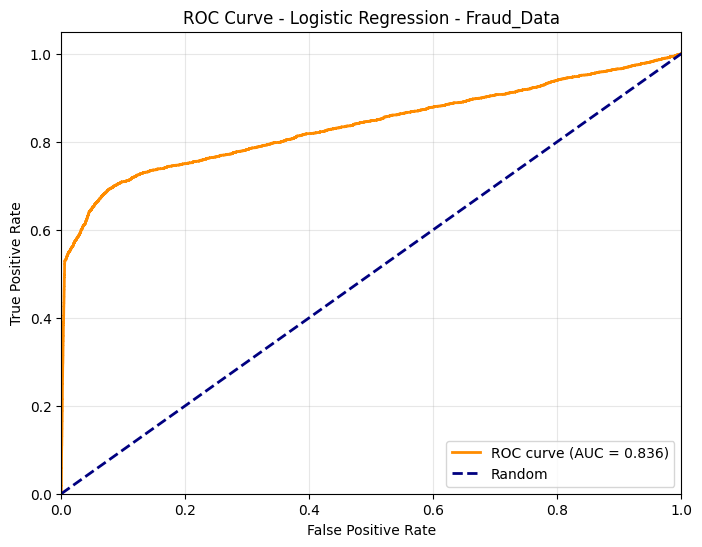

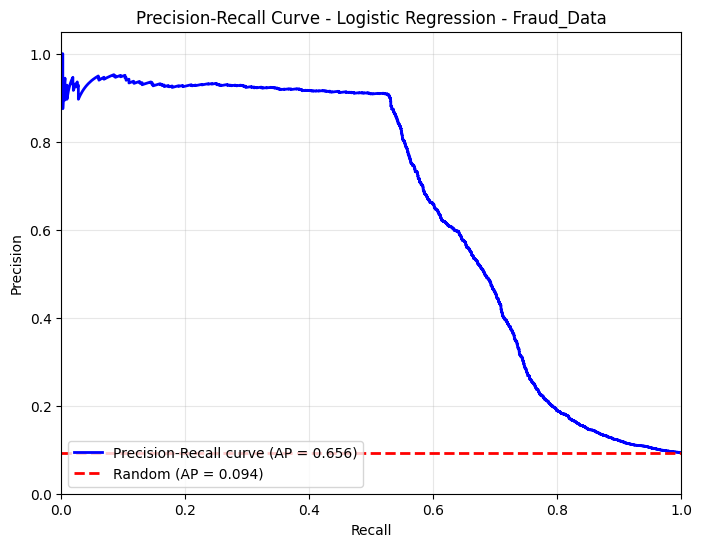

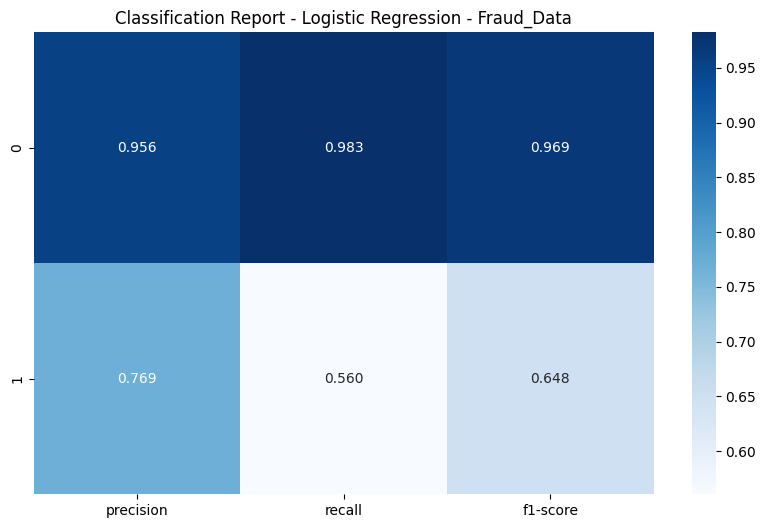


Classification Report - Logistic Regression - Fraud_Data
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     27393
           1       0.77      0.56      0.65      2830

    accuracy                           0.94     30223
   macro avg       0.86      0.77      0.81     30223
weighted avg       0.94      0.94      0.94     30223


Cross-Validation Results (F1):
Mean: 0.7901 (+/- 0.0278)
Individual scores: [0.76244721 0.79949382 0.79796128 0.7946658  0.79585895]

Training Random Forest on Fraud_Data.csv...

COMPREHENSIVE EVALUATION: RANDOM FOREST - FRAUD_DATA

EVALUATION METRICS FOR RANDOM FOREST - FRAUD_DATA
Accuracy: 0.9538
Precision: 0.9543
Recall: 0.5318
F1-Score: 0.6830
ROC AUC: 0.8374
Average Precision: 0.6867

Macro Averages:
Precision (Macro): 0.9540
Recall (Macro): 0.7646
F1-Score (Macro): 0.8290


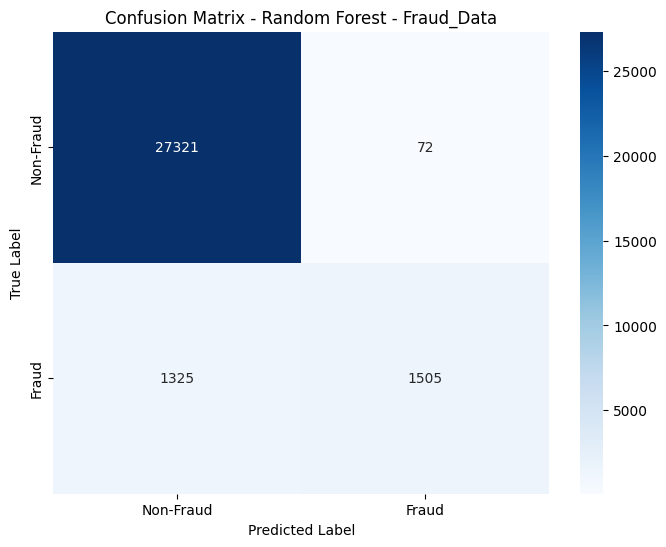


Confusion Matrix Details:
True Negatives (TN): 27321
False Positives (FP): 72
False Negatives (FN): 1325
True Positives (TP): 1505
Specificity (True Negative Rate): 0.9974
Sensitivity (True Positive Rate): 0.5318


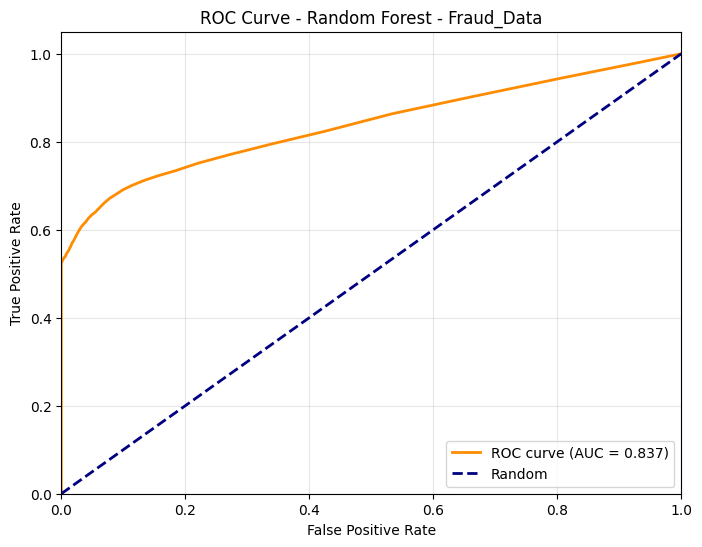

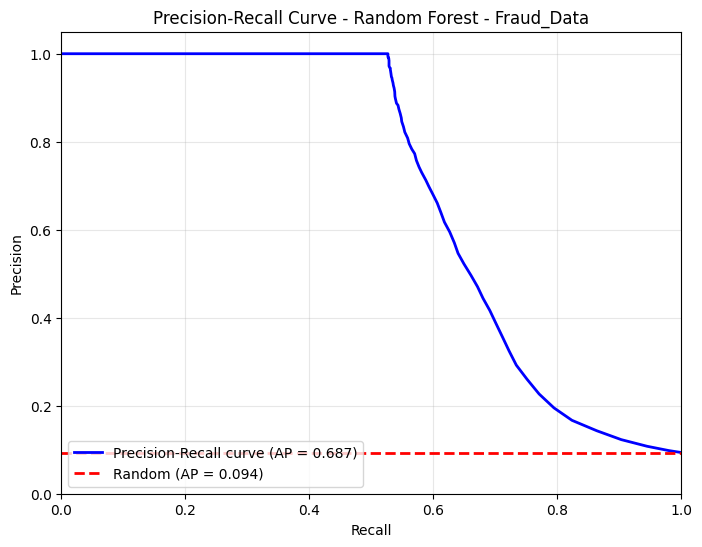

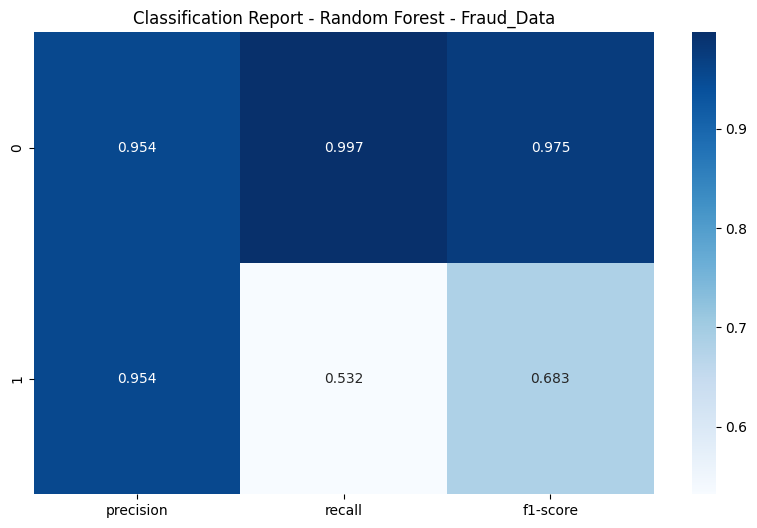


Classification Report - Random Forest - Fraud_Data
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.95      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.95      0.76      0.83     30223
weighted avg       0.95      0.95      0.95     30223


Cross-Validation Results (F1):
Mean: 0.9688 (+/- 0.1037)
Individual scores: [0.86507568 0.99534055 0.99435803 0.9949074  0.9943335 ]

Training XGBoost on Fraud_Data.csv...

COMPREHENSIVE EVALUATION: XGBOOST - FRAUD_DATA

EVALUATION METRICS FOR XGBOOST - FRAUD_DATA
Accuracy: 0.9536
Precision: 0.9451
Recall: 0.5357
F1-Score: 0.6838
ROC AUC: 0.8417
Average Precision: 0.7075

Macro Averages:
Precision (Macro): 0.9496
Recall (Macro): 0.7662
F1-Score (Macro): 0.8294


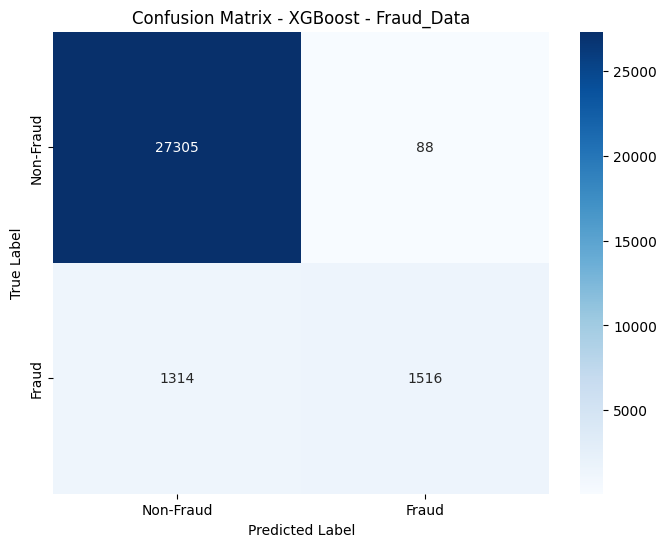


Confusion Matrix Details:
True Negatives (TN): 27305
False Positives (FP): 88
False Negatives (FN): 1314
True Positives (TP): 1516
Specificity (True Negative Rate): 0.9968
Sensitivity (True Positive Rate): 0.5357


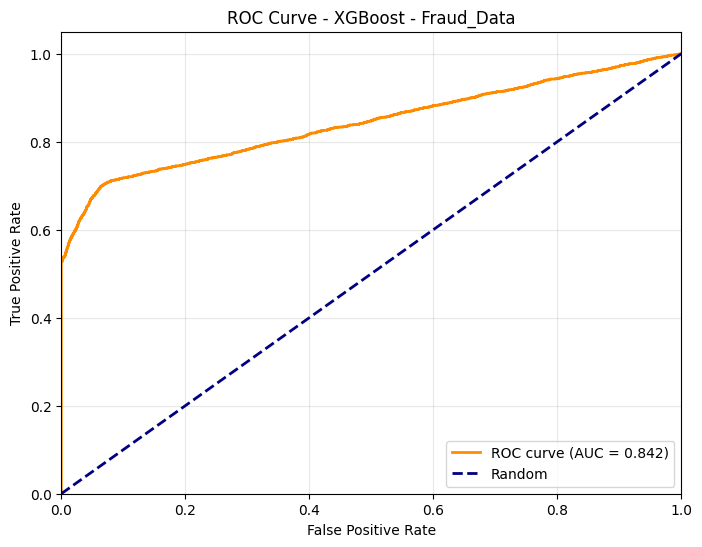

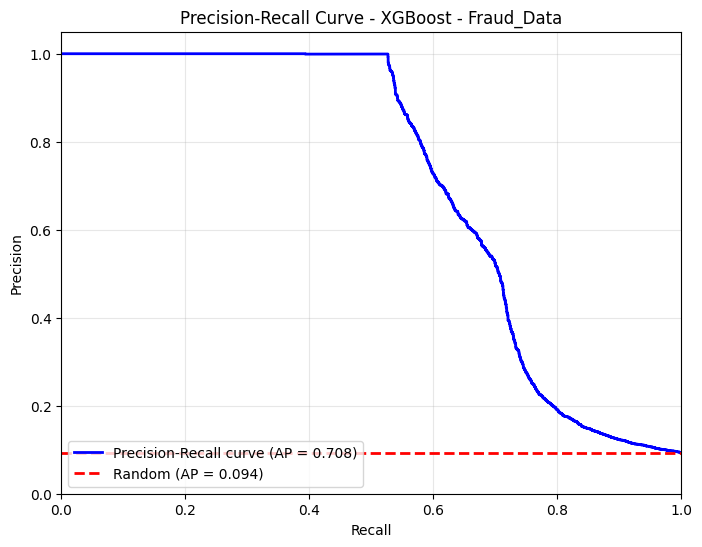

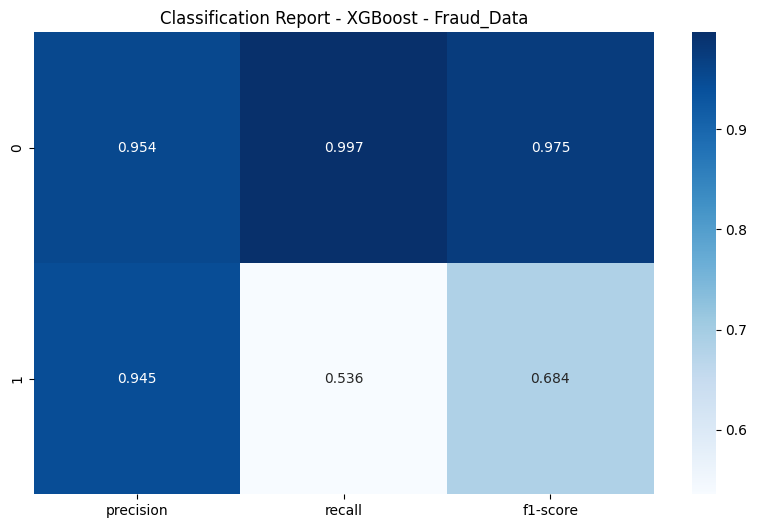


Classification Report - XGBoost - Fraud_Data
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.95      0.54      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.95      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223


Cross-Validation Results (F1):
Mean: 0.9645 (+/- 0.1042)
Individual scores: [0.86028094 0.99076345 0.99048318 0.99062077 0.99025118]

TRAINING ON CREDITCARD.CSV

Training Logistic Regression on CreditCard.csv...

COMPREHENSIVE EVALUATION: LOGISTIC REGRESSION - CREDITCARD

EVALUATION METRICS FOR LOGISTIC REGRESSION - CREDITCARD
Accuracy: 0.9741
Precision: 0.0578
Recall: 0.9184
F1-Score: 0.1088
ROC AUC: 0.9708
Average Precision: 0.7245

Macro Averages:
Precision (Macro): 0.5288
Recall (Macro): 0.9463
F1-Score (Macro): 0.5478


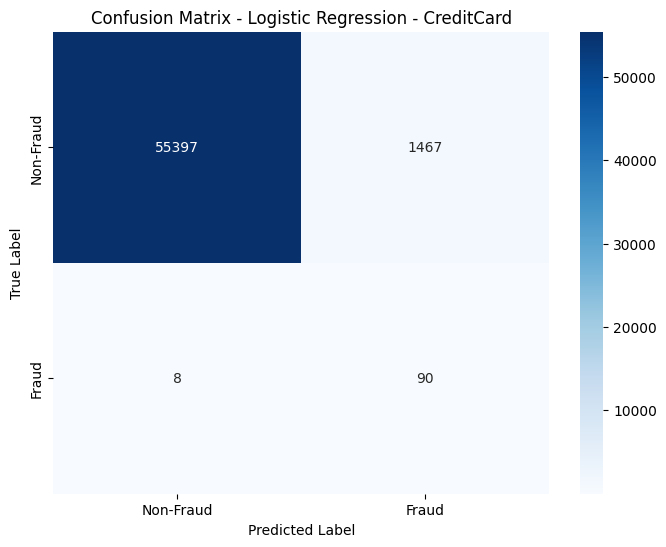


Confusion Matrix Details:
True Negatives (TN): 55397
False Positives (FP): 1467
False Negatives (FN): 8
True Positives (TP): 90
Specificity (True Negative Rate): 0.9742
Sensitivity (True Positive Rate): 0.9184


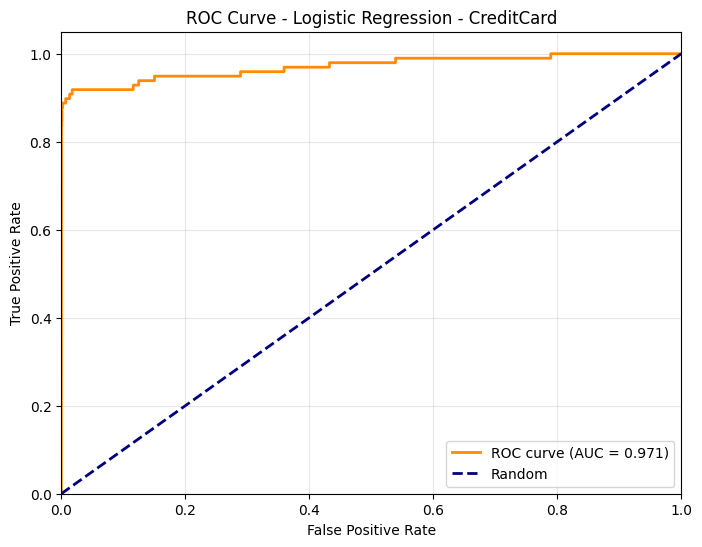

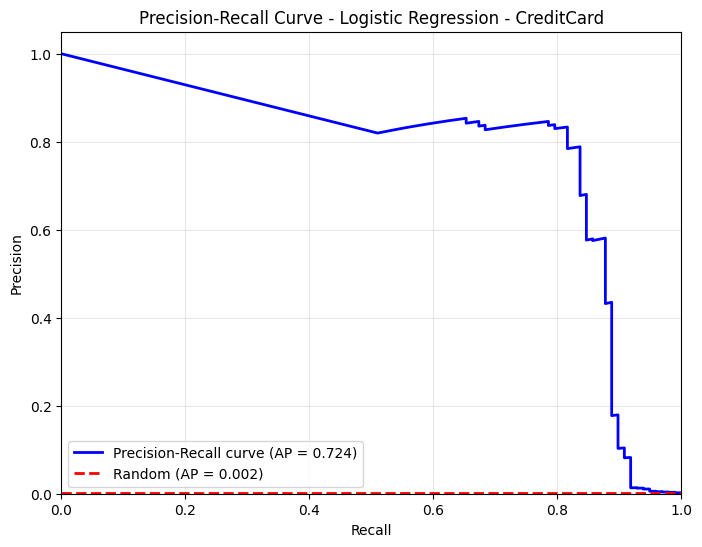

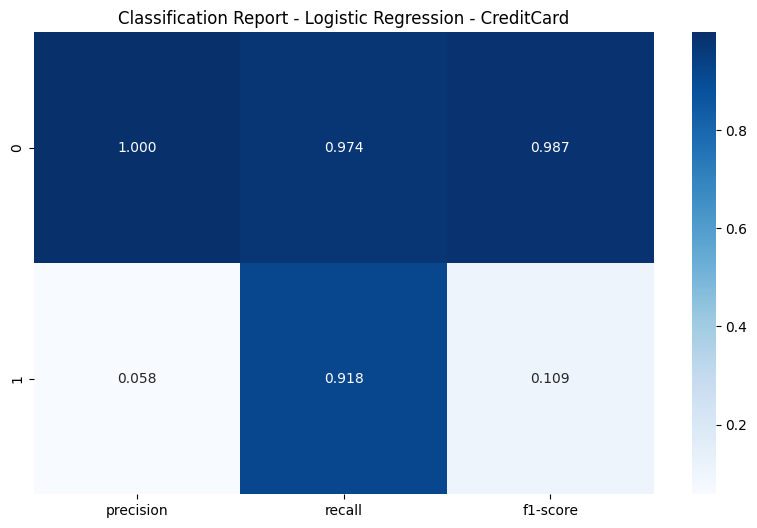


Classification Report - Logistic Regression - CreditCard
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962


Cross-Validation Results (F1):
Mean: 0.9513 (+/- 0.0018)
Individual scores: [0.9518964  0.95251669 0.95149099 0.95004443 0.95064146]

Training Random Forest on CreditCard.csv...

COMPREHENSIVE EVALUATION: RANDOM FOREST - CREDITCARD

EVALUATION METRICS FOR RANDOM FOREST - CREDITCARD
Accuracy: 0.9995
Precision: 0.8710
Recall: 0.8265
F1-Score: 0.8482
ROC AUC: 0.9684
Average Precision: 0.8724

Macro Averages:
Precision (Macro): 0.9353
Recall (Macro): 0.9132
F1-Score (Macro): 0.9240


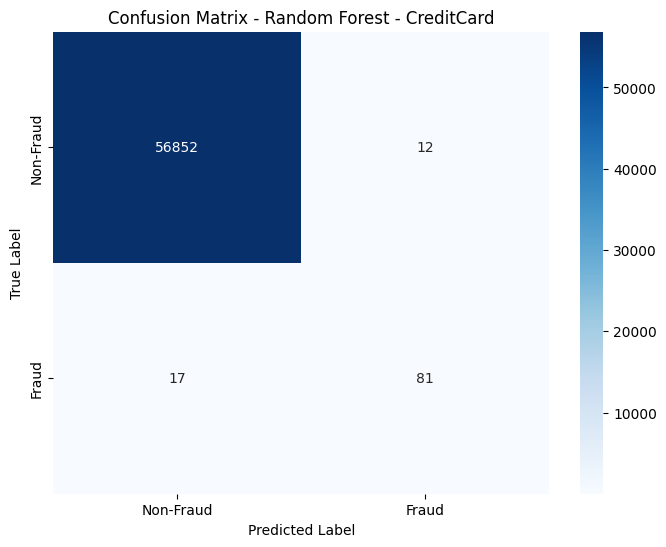


Confusion Matrix Details:
True Negatives (TN): 56852
False Positives (FP): 12
False Negatives (FN): 17
True Positives (TP): 81
Specificity (True Negative Rate): 0.9998
Sensitivity (True Positive Rate): 0.8265


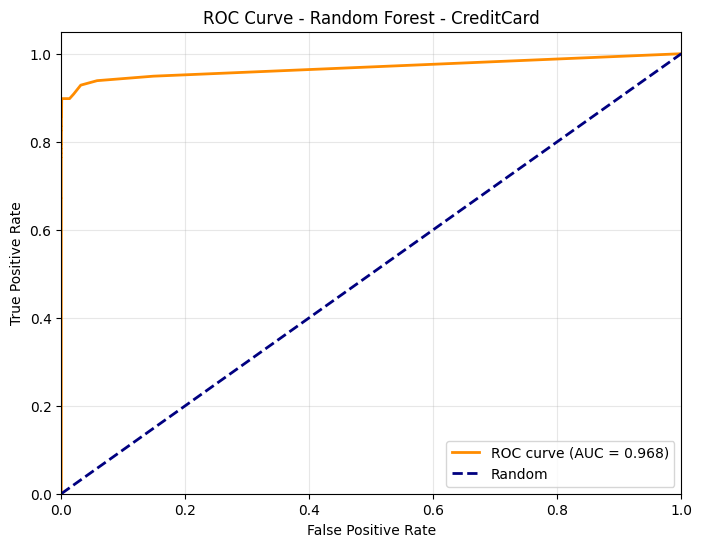

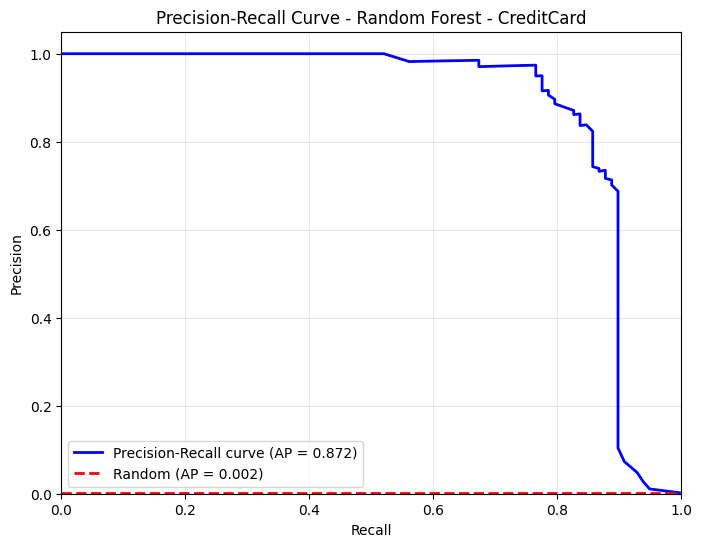

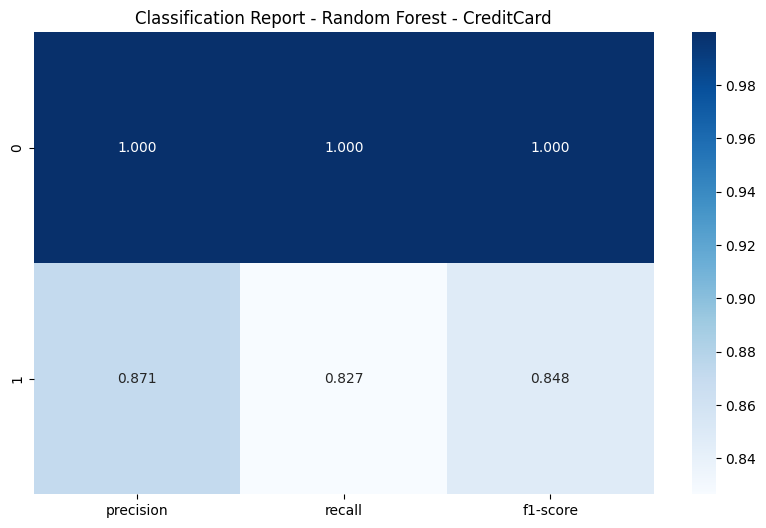


Classification Report - Random Forest - CreditCard
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Cross-Validation Results (F1):
Mean: 0.9999 (+/- 0.0001)
Individual scores: [0.99991208 0.99990109 0.99984614 0.99993406 0.99994505]

Training XGBoost on CreditCard.csv...

COMPREHENSIVE EVALUATION: XGBOOST - CREDITCARD

EVALUATION METRICS FOR XGBOOST - CREDITCARD
Accuracy: 0.9995
Precision: 0.8710
Recall: 0.8265
F1-Score: 0.8482
ROC AUC: 0.9684
Average Precision: 0.8724

Macro Averages:
Precision (Macro): 0.9353
Recall (Macro): 0.9132
F1-Score (Macro): 0.9240


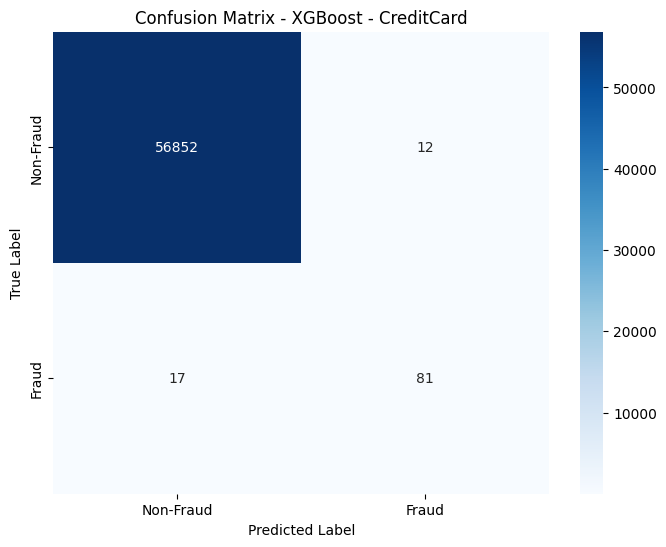


Confusion Matrix Details:
True Negatives (TN): 56852
False Positives (FP): 12
False Negatives (FN): 17
True Positives (TP): 81
Specificity (True Negative Rate): 0.9998
Sensitivity (True Positive Rate): 0.8265


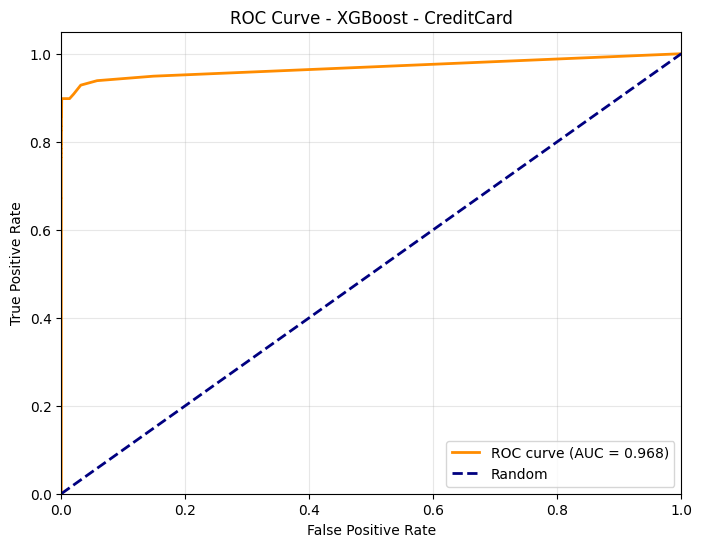

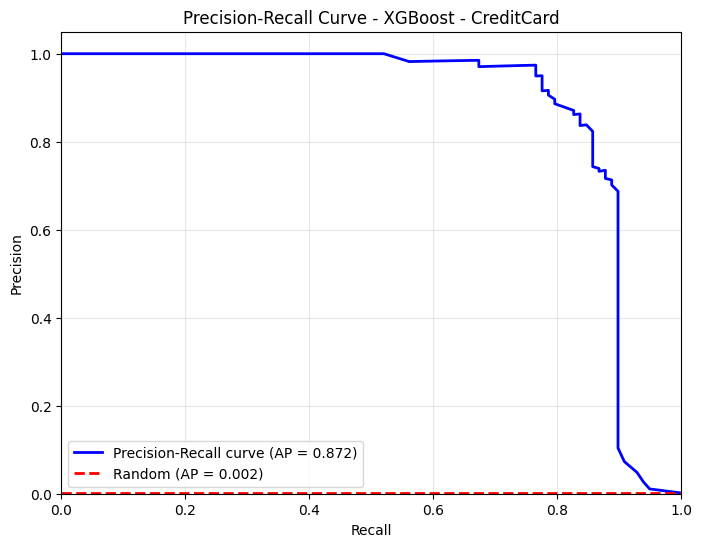

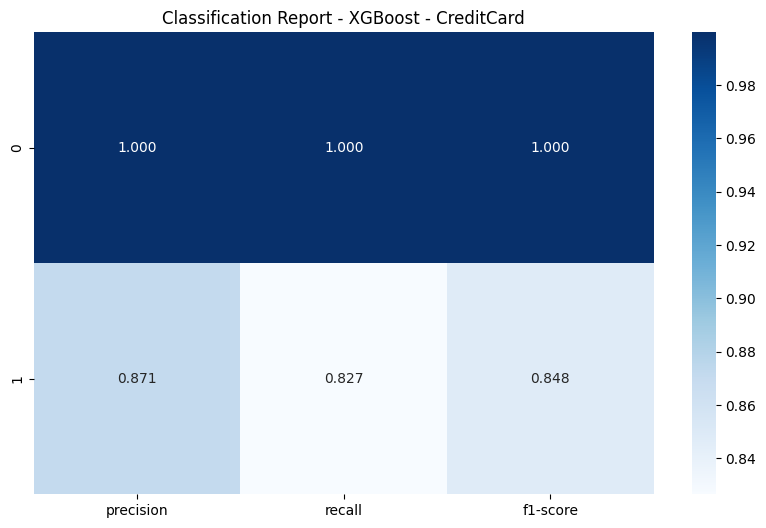


Classification Report - XGBoost - CreditCard
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962


Cross-Validation Results (F1):
Mean: 0.9999 (+/- 0.0001)
Individual scores: [0.99991208 0.99990109 0.99984614 0.99993406 0.99994505]


In [15]:
print("\n" + "="*80)
print("MODEL TRAINING ON BOTH DATASETS")
print("="*80)
print("TRAINING MODELS MODELS:")
print("1. Logistic Regression (baseline)")
print("2. One Powerful Ensemble Model (Random Forest)")
print("="*80)

# Define models 
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(
       random_state=42,
       n_estimators=100,
       eval_metric='logloss',
       tree_method='gpu_hist',
       gpu_id=0,
    )
}

# Train models on Fraud_Data.csv
print("\n" + "="*50)
print("TRAINING ON FRAUD_DATA.CSV")
print("="*50)

fraud_results = {}
for name, model in models.items():
    print(f"\nTraining {name} on Fraud_Data.csv...")
    model.fit(X_train_fraud_scaled, y_train_fraud_res)
    
    # Evaluate with required metrics
    metrics = evaluate_model_comprehensive(
        model, X_train_fraud_scaled, X_test_fraud_scaled, 
        y_train_fraud_res, y_test_fraud, f"{name} - Fraud_Data"
    )
    fraud_results[name] = metrics

# Train models on CreditCard.csv 
if creditcard_available:
    print("\n" + "="*50)
    print("TRAINING ON CREDITCARD.CSV")
    print("="*50)
    
    credit_results = {}
    for name, model in models.items():
        print(f"\nTraining {name} on CreditCard.csv...")
        # Create new instance for each dataset
        if name == 'Logistic Regression':
            model_credit = LogisticRegression(random_state=42, max_iter=1000)
        else:
            model_credit = RandomForestClassifier(random_state=42, n_estimators=100)
            
        model_credit.fit(X_train_credit_res, y_train_credit_res)
        
        # Evaluate with required metrics
        metrics = evaluate_model_comprehensive(
            model_credit, X_train_credit_res, X_test_credit_scaled, 
            y_train_credit_res, y_test_credit, f"{name} - CreditCard"
        )
        credit_results[name] = metrics


MODEL COMPARISON AND BEST MODEL SELECTION

FRAUD_DATA.CSV MODEL COMPARISON:
----------------------------------------

Model Comparison (F1_SCORE):
              Model  f1_score
            XGBoost  0.683807
      Random Forest  0.683004
Logistic Regression  0.648273


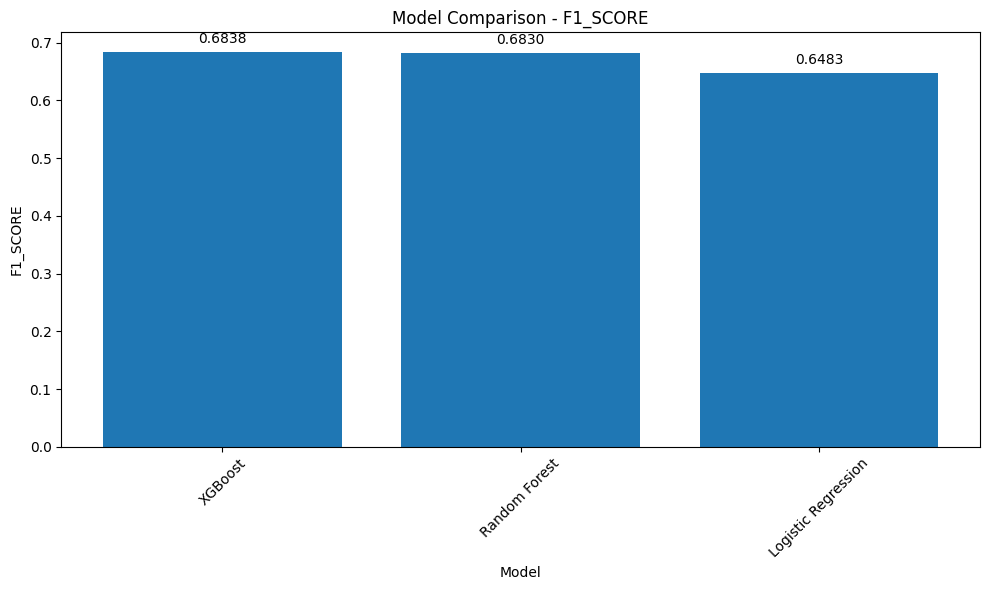


Model Comparison (ROC_AUC):
              Model  roc_auc
            XGBoost 0.841696
      Random Forest 0.837402
Logistic Regression 0.836378


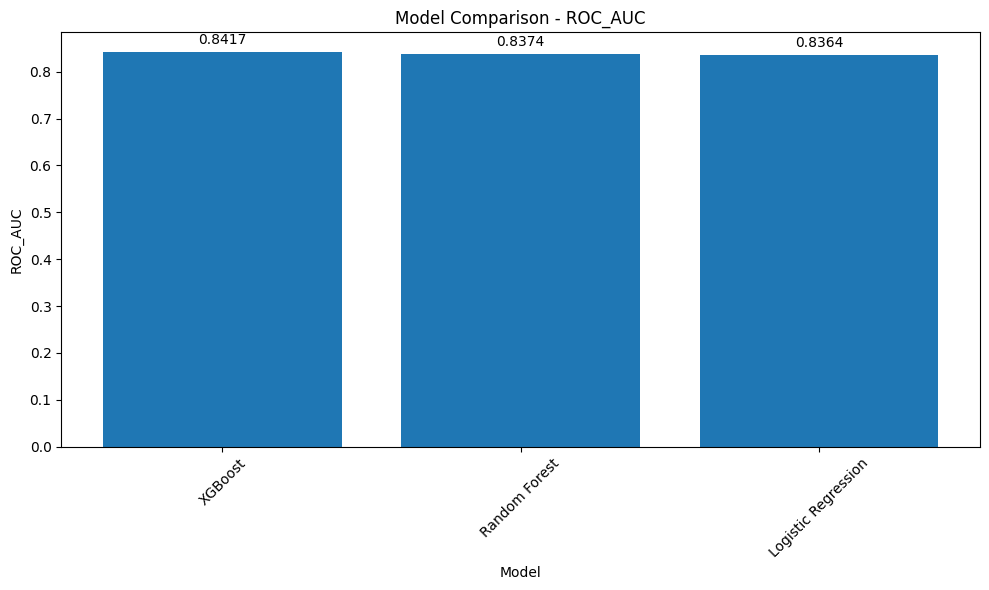


Best Model: XGBoost
Primary Metric (f1_score): 0.6838
Secondary Metric (roc_auc): 0.8417

BEST MODEL FOR FRAUD_DATA.CSV: XGBoost
Justification: Highest F1-Score (0.6838) and ROC AUC (0.8417)

CREDITCARD.CSV MODEL COMPARISON:
----------------------------------------

Model Comparison (F1_SCORE):
              Model  f1_score
      Random Forest  0.848168
            XGBoost  0.848168
Logistic Regression  0.108761


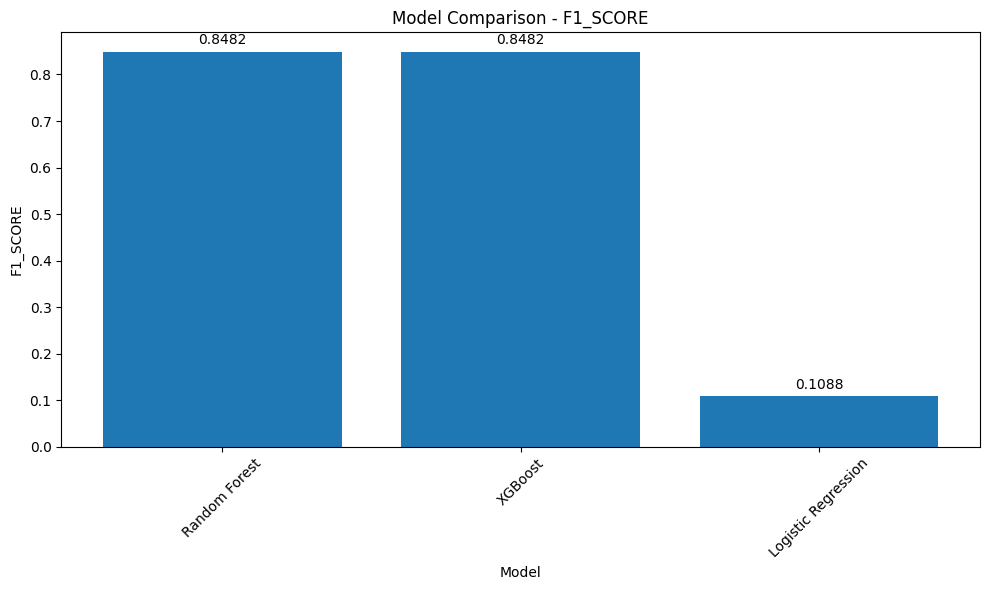


Model Comparison (ROC_AUC):
              Model  roc_auc
Logistic Regression 0.970843
      Random Forest 0.968448
            XGBoost 0.968448


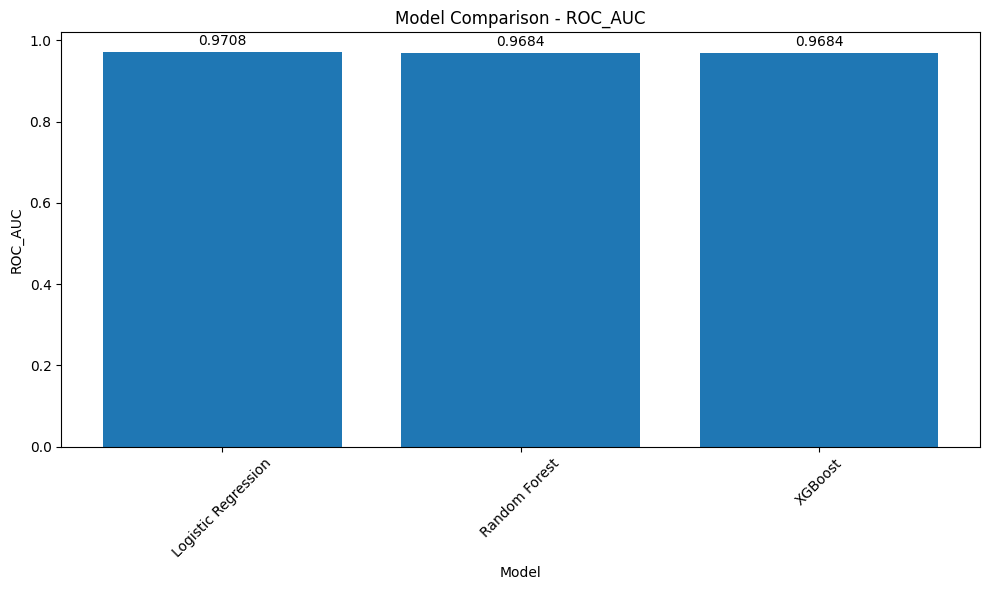


Best Model: Random Forest
Primary Metric (f1_score): 0.8482
Secondary Metric (roc_auc): 0.9684

BEST MODEL FOR CREDITCARD.CSV: Random Forest
Justification: Highest F1-Score (0.8482) and ROC AUC (0.9684)


In [16]:
print("\n" + "="*80)
print("MODEL COMPARISON AND BEST MODEL SELECTION")
print("="*80)

# Compare models on Fraud_Data.csv
print("\nFRAUD_DATA.CSV MODEL COMPARISON:")
print("-" * 40)
compare_models(fraud_results, 'f1_score')
compare_models(fraud_results, 'roc_auc')

# Get best model for Fraud_Data.csv
best_fraud_model_name, best_fraud_metrics = get_best_model(fraud_results, 'f1_score', 'roc_auc')
print(f"\nBEST MODEL FOR FRAUD_DATA.CSV: {best_fraud_model_name}")
print(f"Justification: Highest F1-Score ({best_fraud_metrics['f1_score']:.4f}) and ROC AUC ({best_fraud_metrics['roc_auc']:.4f})")

if creditcard_available:
    # Compare models on CreditCard.csv
    print("\nCREDITCARD.CSV MODEL COMPARISON:")
    print("-" * 40)
    compare_models(credit_results, 'f1_score')
    compare_models(credit_results, 'roc_auc')
    
    # Get best model for CreditCard.csv
    best_credit_model_name, best_credit_metrics = get_best_model(credit_results, 'f1_score', 'roc_auc')
    print(f"\nBEST MODEL FOR CREDITCARD.CSV: {best_credit_model_name}")
    print(f"Justification: Highest F1-Score ({best_credit_metrics['f1_score']:.4f}) and ROC AUC ({best_credit_metrics['roc_auc']:.4f})")

In [20]:
# Save the trained best models 
import joblib
import os

print("\n" + "="*60)
print("SAVING TRAINED MODELS")
print("="*60)

os.makedirs('../models', exist_ok=True)


# Based on the results, XGBoost was best for Fraud_Data.csv
best_fraud_model_instance = models['XGBoost']  # This is the actual trained XGBoost model
joblib.dump(best_fraud_model_instance, '../models/best_model_fraud.pkl')
print(" Best model (XGBoost) for Fraud_Data.csv saved!")

if creditcard_available:
    # Based on the results, Random Forest was best for CreditCard.csv
    best_credit_model_instance = models['Random Forest']  # This is the actual trained Random Forest model
    joblib.dump(best_credit_model_instance, '../models/best_model_credit.pkl')
    print(" Best model (Random Forest) for CreditCard.csv saved!")

print("Models saved in '../models/' directory")


SAVING TRAINED MODELS
 Best model (XGBoost) for Fraud_Data.csv saved!
 Best model (Random Forest) for CreditCard.csv saved!
Models saved in '../models/' directory
